In [ ]:
# load offline trained agent
# load expert agent
# write ensemble class for offline trained agents
# use distributional RL to detect risky states
# use ensembles to detect novel states
# if novelty is above a treshold give control to expert 
# if risk is above a treshold give control to expert
# can conformal prediction give us guaranties about the performance in this setu?p
# empirecally verify if we are able to get the desired performance

In [20]:
import re
import os
import argparse
from copy import deepcopy
import torch
from torch import nn
import numpy as np
import gymnasium as gym
from types import SimpleNamespace
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

from examples.offline.utils import load_buffer_d4rl
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env import SubprocVectorEnv
from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
device = "cuda:1"
seed = 0
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
def parse_value(value):
    # Convert simple types (int, float, bool, None)
    if value.isdigit():
        return int(value)
    elif re.match(r'^\d+\.\d+$', value):
        return float(value)
    elif value == "True":
        return True
    elif value == "False":
        return False
    elif value == "None":
        return None
    elif value.startswith("[") and value.endswith("]"):
        # Convert the list items
        items = re.split(r',(?=[^\]]*(?:\[|$))', value[1:-1])
        return [parse_value(item.strip()) for item in items]
    elif value.startswith("(") and value.endswith(")"):
        # Convert the tuple items
        items = re.split(r',(?=[^\)]*(?:\(|$))', value[1:-1])
        # Special case for single-item tuple
        if len(items) == 2 and items[0].strip() != '':
            return (parse_value(items[0].strip()),)
        return tuple(parse_value(item.strip()) for item in items)
    elif value.startswith("'") and value.endswith("'"):
        return value[1:-1]
    # Else, return the value as-is
    return value

def get_args(event_file):
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load the file
    # Get the text data
    texts = ea.Tags()["tensors"]
    # Extract the actual text content
    text_data = {}
    for tag in texts:
        events = ea.Tensors(tag)
        for event in events:
            # You can extract the wall_time and step if needed
            # wall_time, step, value = event.wall_time, event.step, event.text
            text_data[tag] = event.tensor_proto.string_val
    data = text_data['args/text_summary'][0]
    # Convert bytes to string
    data_str = data.decode('utf-8')
    # Remove the "Namespace(" prefix and the trailing ")"
    data_str = data_str[len("Namespace("):-1]
    # Split into key-value pairs
    key_values = re.split(r',(?=\s\w+=)', data_str)
    # Parse each key-value pair
    args_dict = {}
    for kv in key_values:
        key, value = kv.split('=', 1)
        key = key.strip()
        args_dict[key] = parse_value(value)
    args = SimpleNamespace(**args_dict)
    try:
        env = gym.make(args.task)
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.zeros(1, requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    except Exception:
        pass
    return args

In [33]:
def get_dsac_args():
    args = argparse.Namespace(
        task="Hopper-v2",
        risk_type="wang",
        buffer_size=1000000,
        hidden_sizes=[256, 256, 256],
        # hidden_sizes=[256, 256],
        actor_lr=1e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        auto_alpha=False,
        alpha=0.6,
        alpha_lr=0.0003,
        start_timesteps=1,
        epoch=200,
        step_per_epoch=5000,
        step_per_collect=1,
        update_per_step=1,
        batch_size=256,
        training_num=1,
        test_num=10,
        distortion_param=0.75,
    )
    return args

In [5]:
def load_policy(args, path):
    env = gym.make(args.task)
    args.state_shape = env.observation_space.shape or env.observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    # model
    net_a = Net(args.state_shape, hidden_sizes=args.hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        args.action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    target_entropy = -np.prod(env.action_space.shape)
    if args.auto_alpha:
        log_alpha = torch.tensor([np.log(args.alpha)], requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type='wang',
        tau=args.tau,
        gamma=args.gamma,
        alpha=args.alpha,
        action_space=env.action_space,
        device=device,
        distortion_param=0.75,
    )
    dirname = os.path.dirname(path)
    if os.path.isfile(os.path.join(dirname, "actor.pth")):
        policy.actor.load_state_dict(torch.load(os.path.join(dirname, "actor.pth"), map_location=device))
        print("Loaded actor from: ", os.path.join(dirname, "actor.pth"))
    if os.path.isfile(os.path.join(dirname, "critic1.pth")):
        policy.critic1.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        policy.critic1_old.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        print("Loaded critic1 from: ", os.path.join(dirname, "critic1.pth"))
    if os.path.isfile(os.path.join(dirname, "critic2.pth")):
        policy.critic2.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        policy.critic2_old.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        print("Loaded critic2 from: ", os.path.join(dirname, "critic2.pth"))
    else:
        policy.load_state_dict(torch.load(path, map_location=device))
        print("Loaded agent from: ", path)
    return policy

def load_behavioral_crtitic(args, path):
    behavioral_critic = QuantileMlp(
        input_size=args.state_shape[0] + args.action_shape[0],
        hidden_sizes=args.hidden_sizes,
        device=device,
    ).to(device)
    behavioral_critic.load_state_dict(torch.load(path, map_location=device))
    return behavioral_critic

def get_model(log_path, type=None):
    if type == "behavioral":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'model.pth')
        policy = load_behavioral_crtitic(args, resume_path)
    elif type == "codac":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    else:
        args = get_dsac_args()
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    return policy

In [34]:
log_path1 = "/data/user/R901105/dev/log/Hopper-v2/codac_bc/neutral/0/231102-150037"
offline_policy1 = get_model(log_path1)

Loaded actor from:  /data/user/R901105/dev/log/Hopper-v2/codac_bc/neutral/0/231102-150037/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/Hopper-v2/codac_bc/neutral/0/231102-150037/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/Hopper-v2/codac_bc/neutral/0/231102-150037/critic2.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [8]:
log_path = "/data/user/R901105/dev/log/Hopper-v4/dsac/cvar/0/230831-103319"
expert_policy = get_model(log_path) 
# expert_policy.eval();

Loaded agent from:  /data/user/R901105/dev/log/Hopper-v4/dsac/cvar/0/230831-103319/policy.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [25]:
task = "Hopper-v2"
env_num = 20
env = gym.make(task)

In [35]:
offline_data = load_buffer_d4rl("hopper-medium-v2")

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 21/21 [00:01<00:00, 15.61it/s]


# give control to the expert policy based on epistemic and aleatoric uncertainties

In [11]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space, id_data):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy
        self.update_kde(id_data)
        self.cede_ctrl_prob = 1

    def update_kde(self, id_data):
        self.kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(id_data)
        self.density_threshold = np.percentile(self.kde.score_samples(id_data), 1)  

    def forward(self, batch: RolloutBatchProtocol, state=None, n_repeat=100, **kwargs):
        bsz = len(batch.obs)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.base_policy.eval()
        self.expert_policy.eval()
        with torch.no_grad():
            expert_result = self.expert_policy(batch)
            base_result = self.base_policy(batch)
            expert_qvalues1 = self.expert_policy.critic1(batch.obs, expert_result.act)
            expert_qvalues2 = self.expert_policy.critic2(batch.obs, expert_result.act)
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            base_qvalues1 = self.base_policy.critic1(batch.obs, base_result.act)
            base_qvalues2 = self.base_policy.critic2(batch.obs, base_result.act)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
        risky = base_qvalues[:, 0] < expert_qvalues[:, 0] 
        log_dens = self.kde.score_samples(batch.obs.cpu().numpy())
        novel = log_dens < self.density_threshold
        novel = to_torch(novel, dtype=torch.float32, device=device)
        cede_ctrl = torch.logical_or(risky, novel)
        # if bsz == 1:
        #     not_cede_ctrl = ~cede_ctrl * (torch.rand(1, device=device) >= self.cede_ctrl_prob)
        #     cede_ctrl = ~not_cede_ctrl
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act.mean(0), base_result.act.mean(0))
        self.cede_ctrl_prob *= 0.99995
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl, 'novel': novel, 'risky': risky})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

# estimate novelty_threshold from the data

In [36]:
offline_batch, _ = offline_data.sample(5000)
mixed_policy = MixedPolicy(offline_policy1, expert_policy, env.action_space, offline_batch.obs)
mixed_policy.density_threshold

-17.203103249897097

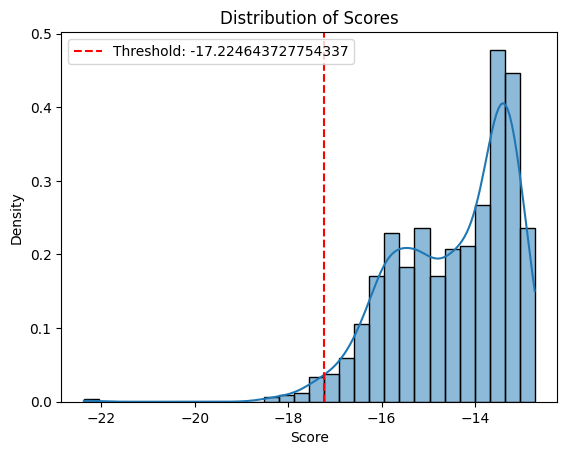

In [13]:
import seaborn as sns

# Assuming 'scores' and 'mixed_policy.density_threshold' are already defined
batch, _ = offline_data.sample(1000)
scores = mixed_policy.kde.score_samples(batch.obs)

# Plotting the distribution of scores
sns.histplot(scores, kde=True, stat="density", bins=30)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Distribution of Scores")

# Adding a vertical line for the threshold
plt.axvline(x=mixed_policy.density_threshold, color='r', linestyle='--', label=f'Threshold: {mixed_policy.density_threshold}')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

# perform continual learning and observe the evolution of numbers of calls to the expert

In [28]:
test_envs = SubprocVectorEnv([lambda: gym.make(task) for _ in range(5)])
test_envs.seed(seed);

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/e

In [37]:
test_buffer = VectorReplayBuffer(5000, 5)
train_collector = Collector(mixed_policy, env, offline_data)
test_collector = Collector(mixed_policy, test_envs, test_buffer)

/data/user/R901105/dev/my_fork/tianshou/tianshou/data/collector.py:70: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [16]:
def get_returns(policy, n, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    novel = []
    risky = []
    for _ in range(n):
        obs, info = env.reset()
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
            novel_ep = []
            risky_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
                novel_ep.append(result.policy.novel.cpu().squeeze().numpy())
                risky_ep.append(result.policy.risky.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
            novel.append(np.array(novel_ep).mean())
            risky.append(np.array(risky_ep).mean())
    if return_cede_ctrl:
        return np.array(returns).squeeze().mean(),  np.array(cede_ctrl).mean(), np.array(novel).mean(), np.array(risky).mean()
    return np.array(returns).squeeze().mean()

In [38]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join(task, "mixed", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)
writer.add_text("args", str(get_dsac_args()))

In [39]:
n = 2
expert_returns = get_returns(expert_policy, n)
def test_fn(num_epoch: int, step_idx: int):        
    returns, cede_ctrl, novel, risky = get_returns(mixed_policy, n, True)
    risky_returns = get_returns(offline_policy1, n)
    id_data = offline_data.sample(5000)[0].obs
    mixed_policy.update_kde(id_data)
    print("Mixed return: ", returns, "Suboptimal return: ", risky_returns, "Expert return: ", expert_returns, "Cede Control: ", cede_ctrl, "novel: ", novel, "risky: ", risky)
    # Log data to TensorBoard
    writer.add_scalar("Stats/Mixed return", returns, global_step=step_idx)
    writer.add_scalar("Stats/Suboptimal return", risky_returns, global_step=step_idx)
    writer.add_scalar("Stats/Expert return", expert_returns, global_step=step_idx)
    writer.add_scalar("Stats/Cede Control", cede_ctrl, global_step=step_idx)
    writer.add_scalar("Stats/Novel", novel, global_step=step_idx)
    writer.add_scalar("Stats/Risky", risky, global_step=step_idx)

In [40]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=mixed_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=1000,
    step_per_collect=1,
    episode_per_test=1,
    batch_size=256,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Mixed return:  3163.9349469458 Suboptimal return:  2061.8856090002537 Expert return:  3163.2014233630116 Cede Control:  1.0 novel:  0.222 risky:  1.0


Epoch #1: 1001it [00:27, 35.82it/s, env_step=1000, gradient_step=1000, len=1, loss/actor=-284.086, loss/critic1=1.768, loss/critic2=1.766, n/ep=0, n/st=1, rew=4.38]                          


Mixed return:  3161.6405424161035 Suboptimal return:  2583.265083827798 Expert return:  3163.2014233630116 Cede Control:  1.0 novel:  0.16749999 risky:  1.0
Epoch #1: test_reward: 3162.846364 ± 0.000000, best_reward: 3163.199245 ± 0.000000 in #0


Epoch #2: 1001it [00:28, 35.14it/s, env_step=2000, gradient_step=2000, len=1000, loss/actor=-303.188, loss/critic1=1.500, loss/critic2=1.499, n/ep=0, n/st=1, rew=3165.70]                          


Mixed return:  3164.2774611279383 Suboptimal return:  1382.0580599004975 Expert return:  3163.2014233630116 Cede Control:  0.938 novel:  0.1825 risky:  0.938
Epoch #2: test_reward: 3165.689627 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #3: 1001it [00:27, 36.40it/s, env_step=3000, gradient_step=3000, len=1000, loss/actor=-322.484, loss/critic1=1.266, loss/critic2=1.265, n/ep=0, n/st=1, rew=3162.20]                          


Mixed return:  3162.1606348077503 Suboptimal return:  2855.4256404269518 Expert return:  3163.2014233630116 Cede Control:  0.936 novel:  0.136 risky:  0.9345000000000001
Epoch #3: test_reward: 3159.940698 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #4: 1001it [00:27, 36.15it/s, env_step=4000, gradient_step=4000, len=1000, loss/actor=-341.182, loss/critic1=1.073, loss/critic2=1.071, n/ep=0, n/st=1, rew=3163.14]                          


Mixed return:  2815.236592367686 Suboptimal return:  1565.3528200281282 Expert return:  3163.2014233630116 Cede Control:  0.0085 novel:  0.0085 risky:  0.0
Epoch #4: test_reward: 2834.794537 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #5: 1001it [00:28, 35.23it/s, env_step=5000, gradient_step=5000, len=1000, loss/actor=-358.969, loss/critic1=0.922, loss/critic2=0.921, n/ep=0, n/st=1, rew=3167.68]                          


Mixed return:  2810.766477007869 Suboptimal return:  2721.3967897194457 Expert return:  3163.2014233630116 Cede Control:  0.0085 novel:  0.0085 risky:  0.0
Epoch #5: test_reward: 2779.035894 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #6: 1001it [00:28, 34.71it/s, env_step=6000, gradient_step=6000, len=1000, loss/actor=-374.802, loss/critic1=0.818, loss/critic2=0.814, n/ep=0, n/st=1, rew=2778.78]                          


Mixed return:  2889.0466004163077 Suboptimal return:  2875.4071098841496 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #6: test_reward: 2869.009457 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #7: 1001it [00:28, 35.59it/s, env_step=7000, gradient_step=7000, len=1000, loss/actor=-390.305, loss/critic1=0.748, loss/critic2=0.748, n/ep=0, n/st=1, rew=2889.43]                          


Mixed return:  2966.149062847643 Suboptimal return:  2956.6900941590384 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #7: test_reward: 2945.544927 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #8: 1001it [00:28, 35.19it/s, env_step=8000, gradient_step=8000, len=1000, loss/actor=-404.005, loss/critic1=0.693, loss/critic2=0.690, n/ep=0, n/st=1, rew=2947.49]                          


Mixed return:  3004.643359881984 Suboptimal return:  2987.2425017260266 Expert return:  3163.2014233630116 Cede Control:  0.0125 novel:  0.0125 risky:  0.0
Epoch #8: test_reward: 3034.986531 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #9: 1001it [00:27, 36.08it/s, env_step=9000, gradient_step=9000, len=1000, loss/actor=-419.340, loss/critic1=0.645, loss/critic2=0.644, n/ep=0, n/st=1, rew=3006.35]                          


Mixed return:  3047.2535353544126 Suboptimal return:  3053.219726318188 Expert return:  3163.2014233630116 Cede Control:  0.0095 novel:  0.009500001 risky:  0.0
Epoch #9: test_reward: 3035.247813 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #10: 1001it [00:27, 35.78it/s, env_step=10000, gradient_step=10000, len=1000, loss/actor=-432.469, loss/critic1=0.617, loss/critic2=0.615, n/ep=0, n/st=1, rew=3021.79]                          


Mixed return:  3028.735605195746 Suboptimal return:  3070.9539667711333 Expert return:  3163.2014233630116 Cede Control:  0.0045000000000000005 novel:  0.0045 risky:  0.0
Epoch #10: test_reward: 3042.355990 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #11: 1001it [00:28, 35.64it/s, env_step=11000, gradient_step=11000, len=1000, loss/actor=-444.444, loss/critic1=0.581, loss/critic2=0.579, n/ep=0, n/st=1, rew=3037.11]                          


Mixed return:  3068.0253917817054 Suboptimal return:  3089.1604730691656 Expert return:  3163.2014233630116 Cede Control:  0.008 novel:  0.007999999 risky:  0.0
Epoch #11: test_reward: 3060.613131 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #12: 1001it [00:27, 36.24it/s, env_step=12000, gradient_step=12000, len=1000, loss/actor=-456.528, loss/critic1=0.566, loss/critic2=0.565, n/ep=0, n/st=1, rew=3052.58]                          


Mixed return:  3069.3208551308953 Suboptimal return:  3036.1394498083664 Expert return:  3163.2014233630116 Cede Control:  0.0025 novel:  0.0025000002 risky:  0.0
Epoch #12: test_reward: 3068.222918 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #13: 1001it [00:28, 35.44it/s, env_step=13000, gradient_step=13000, len=1000, loss/actor=-468.829, loss/critic1=0.535, loss/critic2=0.531, n/ep=0, n/st=1, rew=3113.05]                          


Mixed return:  3092.3218867308 Suboptimal return:  3111.621814453917 Expert return:  3163.2014233630116 Cede Control:  0.0005 novel:  0.0005 risky:  0.0
Epoch #13: test_reward: 3120.182740 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #14: 1001it [00:27, 36.02it/s, env_step=14000, gradient_step=14000, len=1000, loss/actor=-479.473, loss/critic1=0.525, loss/critic2=0.523, n/ep=0, n/st=1, rew=3090.63]                          


Mixed return:  3092.861881770953 Suboptimal return:  3088.856299480599 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #14: test_reward: 3100.595297 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #15: 1001it [00:27, 36.52it/s, env_step=15000, gradient_step=15000, len=1000, loss/actor=-489.689, loss/critic1=0.522, loss/critic2=0.521, n/ep=0, n/st=1, rew=3139.82]                          


Mixed return:  3139.506809999679 Suboptimal return:  3136.7099446731145 Expert return:  3163.2014233630116 Cede Control:  0.0025 novel:  0.0025 risky:  0.0
Epoch #15: test_reward: 3142.548975 ± 0.000000, best_reward: 3165.689627 ± 0.000000 in #2


Epoch #16: 1001it [00:27, 36.30it/s, env_step=16000, gradient_step=16000, len=1000, loss/actor=-499.976, loss/critic1=0.525, loss/critic2=0.524, n/ep=0, n/st=1, rew=3121.58]                          


Mixed return:  3163.342304014507 Suboptimal return:  3167.2780268495726 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #16: test_reward: 3168.833279 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #17: 1001it [00:28, 35.52it/s, env_step=17000, gradient_step=17000, len=1000, loss/actor=-510.156, loss/critic1=0.532, loss/critic2=0.530, n/ep=0, n/st=1, rew=3121.86]                          


Mixed return:  3107.4205166354554 Suboptimal return:  3112.158994583344 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #17: test_reward: 3105.398846 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #18: 1001it [00:29, 34.29it/s, env_step=18000, gradient_step=18000, len=1000, loss/actor=-518.818, loss/critic1=0.530, loss/critic2=0.524, n/ep=0, n/st=1, rew=3134.39]                          


Mixed return:  3114.9971207498143 Suboptimal return:  3112.92038824646 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #18: test_reward: 3115.139812 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #19: 1001it [00:28, 34.77it/s, env_step=19000, gradient_step=19000, len=1000, loss/actor=-527.636, loss/critic1=0.548, loss/critic2=0.547, n/ep=0, n/st=1, rew=3120.54]                          


Mixed return:  3072.4343414118566 Suboptimal return:  3063.366864159471 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #19: test_reward: 3061.598856 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #20: 1001it [00:28, 35.65it/s, env_step=20000, gradient_step=20000, len=1000, loss/actor=-536.052, loss/critic1=0.536, loss/critic2=0.534, n/ep=0, n/st=1, rew=3109.53]                          


Mixed return:  3019.4122600489954 Suboptimal return:  3020.8424151229337 Expert return:  3163.2014233630116 Cede Control:  0.0095 novel:  0.009500001 risky:  0.0
Epoch #20: test_reward: 3036.353014 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #21: 1001it [00:27, 36.52it/s, env_step=21000, gradient_step=21000, len=1000, loss/actor=-545.139, loss/critic1=0.546, loss/critic2=0.543, n/ep=0, n/st=1, rew=3086.11]                          


Mixed return:  3008.422785369858 Suboptimal return:  3015.7719063090153 Expert return:  3163.2014233630116 Cede Control:  0.009 novel:  0.009 risky:  0.0
Epoch #21: test_reward: 3011.778017 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #22: 1001it [00:27, 36.77it/s, env_step=22000, gradient_step=22000, len=1000, loss/actor=-551.529, loss/critic1=0.539, loss/critic2=0.538, n/ep=0, n/st=1, rew=3024.47]                          


Mixed return:  3069.199390815867 Suboptimal return:  3070.846847895201 Expert return:  3163.2014233630116 Cede Control:  0.010499999999999999 novel:  0.0105 risky:  0.0
Epoch #22: test_reward: 3068.336846 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #23: 1001it [00:27, 36.57it/s, env_step=23000, gradient_step=23000, len=1000, loss/actor=-557.884, loss/critic1=0.534, loss/critic2=0.534, n/ep=0, n/st=1, rew=3049.59]                          


Mixed return:  3042.54643458801 Suboptimal return:  3048.001819438651 Expert return:  3163.2014233630116 Cede Control:  0.011 novel:  0.011 risky:  0.0
Epoch #23: test_reward: 3042.170933 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #24: 1001it [00:27, 35.85it/s, env_step=24000, gradient_step=24000, len=1000, loss/actor=-564.255, loss/critic1=0.543, loss/critic2=0.544, n/ep=0, n/st=1, rew=3038.60]                          


Mixed return:  3056.217875302681 Suboptimal return:  3055.5524994909683 Expert return:  3163.2014233630116 Cede Control:  0.0135 novel:  0.0135 risky:  0.0
Epoch #24: test_reward: 3063.572290 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #25: 1001it [00:28, 35.42it/s, env_step=25000, gradient_step=25000, len=1000, loss/actor=-570.178, loss/critic1=0.546, loss/critic2=0.545, n/ep=0, n/st=1, rew=3049.16]                          


Mixed return:  3094.9837246713973 Suboptimal return:  3106.50621206094 Expert return:  3163.2014233630116 Cede Control:  0.011 novel:  0.011 risky:  0.0
Epoch #25: test_reward: 3102.862431 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #26: 1001it [00:28, 35.14it/s, env_step=26000, gradient_step=26000, len=1000, loss/actor=-576.797, loss/critic1=0.557, loss/critic2=0.557, n/ep=0, n/st=1, rew=3066.85]                          


Mixed return:  3117.29656325084 Suboptimal return:  3136.117368620524 Expert return:  3163.2014233630116 Cede Control:  0.0045000000000000005 novel:  0.0045 risky:  0.0
Epoch #26: test_reward: 3125.667413 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #27: 1001it [00:27, 35.81it/s, env_step=27000, gradient_step=27000, len=1000, loss/actor=-582.129, loss/critic1=0.578, loss/critic2=0.581, n/ep=0, n/st=1, rew=3114.18]                          


Mixed return:  3109.694302973806 Suboptimal return:  3106.803581799997 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #27: test_reward: 3111.630771 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #28: 1001it [00:27, 35.83it/s, env_step=28000, gradient_step=28000, len=1000, loss/actor=-588.189, loss/critic1=0.577, loss/critic2=0.571, n/ep=0, n/st=1, rew=3125.12]                          


Mixed return:  3105.5490031345544 Suboptimal return:  3100.9225122153903 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #28: test_reward: 3108.975160 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #29: 1001it [00:27, 35.90it/s, env_step=29000, gradient_step=29000, len=1000, loss/actor=-593.565, loss/critic1=0.567, loss/critic2=0.569, n/ep=0, n/st=1, rew=3097.43]                          


Mixed return:  3091.9330142772405 Suboptimal return:  3091.2462663982446 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #29: test_reward: 3072.142294 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #30: 1001it [00:28, 35.73it/s, env_step=30000, gradient_step=30000, len=1000, loss/actor=-597.356, loss/critic1=0.571, loss/critic2=0.565, n/ep=0, n/st=1, rew=3109.74]                          


Mixed return:  3085.533536931579 Suboptimal return:  3092.3499230834404 Expert return:  3163.2014233630116 Cede Control:  0.008 novel:  0.008 risky:  0.0
Epoch #30: test_reward: 3090.359873 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #31: 1001it [00:27, 35.80it/s, env_step=31000, gradient_step=31000, len=1000, loss/actor=-602.507, loss/critic1=0.554, loss/critic2=0.553, n/ep=0, n/st=1, rew=3110.93]                          


Mixed return:  3085.943536016235 Suboptimal return:  3086.002075761528 Expert return:  3163.2014233630116 Cede Control:  0.0085 novel:  0.0085 risky:  0.0
Epoch #31: test_reward: 3084.096696 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #32: 1001it [00:27, 35.79it/s, env_step=32000, gradient_step=32000, len=1000, loss/actor=-607.782, loss/critic1=0.565, loss/critic2=0.568, n/ep=0, n/st=1, rew=3103.76]                          


Mixed return:  3104.495361306639 Suboptimal return:  3107.3493516379585 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #32: test_reward: 3099.942392 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #33: 1001it [00:27, 35.80it/s, env_step=33000, gradient_step=33000, len=1000, loss/actor=-614.214, loss/critic1=0.579, loss/critic2=0.578, n/ep=0, n/st=1, rew=3106.10]                          


Mixed return:  3088.686289299487 Suboptimal return:  3088.2587944786674 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #33: test_reward: 3081.669667 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #34: 1001it [00:27, 36.14it/s, env_step=34000, gradient_step=34000, len=1000, loss/actor=-616.844, loss/critic1=0.577, loss/critic2=0.578, n/ep=0, n/st=1, rew=3110.13]                          


Mixed return:  3108.769787842204 Suboptimal return:  3113.1626190059505 Expert return:  3163.2014233630116 Cede Control:  0.0075 novel:  0.0075000003 risky:  0.0
Epoch #34: test_reward: 3090.371041 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #35: 1001it [00:27, 36.87it/s, env_step=35000, gradient_step=35000, len=1000, loss/actor=-622.244, loss/critic1=0.576, loss/critic2=0.576, n/ep=0, n/st=1, rew=3095.67]                          


Mixed return:  3111.6892402505437 Suboptimal return:  3123.6264308365344 Expert return:  3163.2014233630116 Cede Control:  0.0135 novel:  0.013499999 risky:  0.0
Epoch #35: test_reward: 3118.491229 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #36: 1001it [00:27, 36.77it/s, env_step=36000, gradient_step=36000, len=1000, loss/actor=-625.818, loss/critic1=0.580, loss/critic2=0.581, n/ep=0, n/st=1, rew=3082.99]                          


Mixed return:  3120.00026449951 Suboptimal return:  3115.0796556005407 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #36: test_reward: 3118.055449 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #37: 1001it [00:27, 36.82it/s, env_step=37000, gradient_step=37000, len=1000, loss/actor=-629.081, loss/critic1=0.639, loss/critic2=0.637, n/ep=0, n/st=1, rew=3103.20]                          


Mixed return:  3121.7800364680447 Suboptimal return:  3122.662979907356 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #37: test_reward: 3132.648481 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #38: 1001it [00:27, 36.69it/s, env_step=38000, gradient_step=38000, len=1000, loss/actor=-635.063, loss/critic1=0.556, loss/critic2=0.560, n/ep=0, n/st=1, rew=3124.05]                          


Mixed return:  79.2239304298178 Suboptimal return:  79.28161933805481 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #38: test_reward: 79.489570 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #39: 1001it [00:27, 36.54it/s, env_step=39000, gradient_step=39000, len=49, loss/actor=-637.604, loss/critic1=0.584, loss/critic2=0.581, n/ep=0, n/st=1, rew=79.14]                            


Mixed return:  1584.7926307466462 Suboptimal return:  3093.399745026252 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #39: test_reward: 3096.825760 ± 0.000000, best_reward: 3168.833279 ± 0.000000 in #16


Epoch #40: 1001it [00:27, 36.61it/s, env_step=40000, gradient_step=40000, len=314, loss/actor=-639.839, loss/critic1=0.583, loss/critic2=0.583, n/ep=0, n/st=1, rew=912.65]                          


Mixed return:  3200.791275137629 Suboptimal return:  3192.9503458861554 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #40: test_reward: 3186.983342 ± 0.000000, best_reward: 3186.983342 ± 0.000000 in #40


Epoch #41: 1001it [00:27, 36.66it/s, env_step=41000, gradient_step=41000, len=1000, loss/actor=-643.722, loss/critic1=0.561, loss/critic2=0.557, n/ep=0, n/st=1, rew=3141.34]                          


Mixed return:  3136.064473022311 Suboptimal return:  3118.4760329583314 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #41: test_reward: 3140.749986 ± 0.000000, best_reward: 3186.983342 ± 0.000000 in #40


Epoch #42: 1001it [00:27, 36.57it/s, env_step=42000, gradient_step=42000, len=1000, loss/actor=-647.636, loss/critic1=0.585, loss/critic2=0.588, n/ep=0, n/st=1, rew=3143.24]                          


Mixed return:  3180.1769769745742 Suboptimal return:  3183.9924042421135 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #42: test_reward: 3191.808093 ± 0.000000, best_reward: 3191.808093 ± 0.000000 in #42


Epoch #43: 1001it [00:27, 36.72it/s, env_step=43000, gradient_step=43000, len=1000, loss/actor=-651.478, loss/critic1=0.570, loss/critic2=0.566, n/ep=0, n/st=1, rew=3170.54]                          


Mixed return:  3170.418089308324 Suboptimal return:  3163.6321507553257 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #43: test_reward: 3156.463138 ± 0.000000, best_reward: 3191.808093 ± 0.000000 in #42


Epoch #44: 1001it [00:27, 36.57it/s, env_step=44000, gradient_step=44000, len=1000, loss/actor=-654.960, loss/critic1=0.557, loss/critic2=0.558, n/ep=0, n/st=1, rew=3148.68]                          


Mixed return:  3201.661464026431 Suboptimal return:  3199.1953439364534 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #44: test_reward: 3207.677627 ± 0.000000, best_reward: 3207.677627 ± 0.000000 in #44


Epoch #45: 1001it [00:27, 36.64it/s, env_step=45000, gradient_step=45000, len=1000, loss/actor=-657.317, loss/critic1=0.547, loss/critic2=0.543, n/ep=0, n/st=1, rew=3158.24]                          


Mixed return:  3215.7559759349856 Suboptimal return:  3203.8604660745996 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #45: test_reward: 3208.816718 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #46: 1001it [00:27, 36.59it/s, env_step=46000, gradient_step=46000, len=1000, loss/actor=-660.000, loss/critic1=0.548, loss/critic2=0.543, n/ep=0, n/st=1, rew=3183.63]                          


Mixed return:  3203.4285519035598 Suboptimal return:  3201.3691362230984 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #46: test_reward: 3205.211662 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #47: 1001it [00:27, 36.53it/s, env_step=47000, gradient_step=47000, len=1000, loss/actor=-665.913, loss/critic1=0.540, loss/critic2=0.540, n/ep=0, n/st=1, rew=3201.47]                          


Mixed return:  3189.9081977203077 Suboptimal return:  3189.999364431198 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #47: test_reward: 3186.430716 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #48: 1001it [00:27, 36.30it/s, env_step=48000, gradient_step=48000, len=1000, loss/actor=-667.459, loss/critic1=0.505, loss/critic2=0.504, n/ep=0, n/st=1, rew=3201.75]                          


Mixed return:  1410.1499877103047 Suboptimal return:  1353.9424463247037 Expert return:  3163.2014233630116 Cede Control:  0.15418031619427433 novel:  0.15418032 risky:  0.0
Epoch #48: test_reward: 1157.216538 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #49: 1001it [00:27, 36.40it/s, env_step=49000, gradient_step=49000, len=329, loss/actor=-670.784, loss/critic1=0.528, loss/critic2=0.527, n/ep=0, n/st=1, rew=1109.19]                          


Mixed return:  1012.5577772508451 Suboptimal return:  978.1665507188525 Expert return:  3163.2014233630116 Cede Control:  0.10398432941568725 novel:  0.103984326 risky:  0.0
Epoch #49: test_reward: 452.452954 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #50: 1001it [00:29, 34.49it/s, env_step=50000, gradient_step=50000, len=671, loss/actor=-672.097, loss/critic1=0.518, loss/critic2=0.517, n/ep=0, n/st=1, rew=2102.36]                          


Mixed return:  2181.967817988613 Suboptimal return:  2000.3969905722988 Expert return:  3163.2014233630116 Cede Control:  0.11132658959537572 novel:  0.11132659 risky:  0.0
Epoch #50: test_reward: 1270.980801 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #51: 1001it [00:28, 35.61it/s, env_step=51000, gradient_step=51000, len=312, loss/actor=-676.747, loss/critic1=0.514, loss/critic2=0.513, n/ep=0, n/st=1, rew=1050.22]                          


Mixed return:  1942.0815153381595 Suboptimal return:  2903.330047586706 Expert return:  3163.2014233630116 Cede Control:  0.10496342737722048 novel:  0.10344828 risky:  0.0015151515151515152
Epoch #51: test_reward: 1267.350179 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #52: 1001it [00:28, 34.95it/s, env_step=52000, gradient_step=52000, len=379, loss/actor=-679.224, loss/critic1=0.518, loss/critic2=0.520, n/ep=0, n/st=1, rew=1274.23]                          


Mixed return:  2010.46286346722 Suboptimal return:  2020.0394753551323 Expert return:  3163.2014233630116 Cede Control:  0.06563797457518299 novel:  0.065637976 risky:  0.0
Epoch #52: test_reward: 3038.169112 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #53: 1001it [00:27, 35.81it/s, env_step=53000, gradient_step=53000, len=638, loss/actor=-680.521, loss/critic1=0.549, loss/critic2=0.545, n/ep=0, n/st=1, rew=2114.68]                          


Mixed return:  3071.93560684167 Suboptimal return:  3162.8289499447483 Expert return:  3163.2014233630116 Cede Control:  0.034444816053511705 novel:  0.03221516 risky:  0.002229654403567447
Epoch #53: test_reward: 2416.389958 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #54: 1001it [00:28, 35.44it/s, env_step=54000, gradient_step=54000, len=951, loss/actor=-682.428, loss/critic1=0.523, loss/critic2=0.521, n/ep=0, n/st=1, rew=3151.34]                          


Mixed return:  1327.312214002805 Suboptimal return:  671.9332405401484 Expert return:  3163.2014233630116 Cede Control:  0.005736525379382522 novel:  0.0057365256 risky:  0.0
Epoch #54: test_reward: 3157.965908 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #55: 1001it [00:28, 35.53it/s, env_step=55000, gradient_step=55000, len=49, loss/actor=-687.897, loss/critic1=0.499, loss/critic2=0.500, n/ep=0, n/st=1, rew=81.41]                          


Mixed return:  3153.4218153138254 Suboptimal return:  3154.729510433739 Expert return:  3163.2014233630116 Cede Control:  0.005 novel:  0.005 risky:  0.0
Epoch #55: test_reward: 3157.398972 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #56: 1001it [00:27, 36.10it/s, env_step=56000, gradient_step=56000, len=1000, loss/actor=-687.237, loss/critic1=0.513, loss/critic2=0.514, n/ep=0, n/st=1, rew=3207.79]                          


Mixed return:  3133.493374452729 Suboptimal return:  3128.6076032819856 Expert return:  3163.2014233630116 Cede Control:  0.0035 novel:  0.0035 risky:  0.0
Epoch #56: test_reward: 3136.148105 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #57: 1001it [00:27, 36.04it/s, env_step=57000, gradient_step=57000, len=1000, loss/actor=-688.695, loss/critic1=0.524, loss/critic2=0.519, n/ep=0, n/st=1, rew=3151.86]                          


Mixed return:  3156.176294257293 Suboptimal return:  3143.904997605389 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #57: test_reward: 3156.336652 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #58: 1001it [00:27, 36.65it/s, env_step=58000, gradient_step=58000, len=1000, loss/actor=-691.545, loss/critic1=0.536, loss/critic2=0.533, n/ep=0, n/st=1, rew=3143.69]                          


Mixed return:  3139.321002558716 Suboptimal return:  3112.7110167035826 Expert return:  3163.2014233630116 Cede Control:  0.004 novel:  0.0039999997 risky:  0.0
Epoch #58: test_reward: 3106.066161 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #59: 1001it [00:27, 36.70it/s, env_step=59000, gradient_step=59000, len=1000, loss/actor=-691.173, loss/critic1=0.549, loss/critic2=0.546, n/ep=0, n/st=1, rew=3161.54]                          


Mixed return:  3083.2308723444366 Suboptimal return:  3078.2877030970894 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #59: test_reward: 3070.952422 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #60: 1001it [00:27, 36.78it/s, env_step=60000, gradient_step=60000, len=1000, loss/actor=-692.052, loss/critic1=0.543, loss/critic2=0.542, n/ep=0, n/st=1, rew=3117.43]                          


Mixed return:  3071.7068240990184 Suboptimal return:  3066.128866720805 Expert return:  3163.2014233630116 Cede Control:  0.004 novel:  0.0039999997 risky:  0.0
Epoch #60: test_reward: 3083.684677 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #61: 1001it [00:28, 35.24it/s, env_step=61000, gradient_step=61000, len=1000, loss/actor=-693.596, loss/critic1=0.539, loss/critic2=0.544, n/ep=0, n/st=1, rew=3090.81]                          


Mixed return:  3062.937657440516 Suboptimal return:  3056.045174549611 Expert return:  3163.2014233630116 Cede Control:  0.004 novel:  0.0039999997 risky:  0.0
Epoch #61: test_reward: 3056.211327 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #62: 1001it [00:28, 35.67it/s, env_step=62000, gradient_step=62000, len=1000, loss/actor=-694.982, loss/critic1=0.519, loss/critic2=0.520, n/ep=0, n/st=1, rew=3062.97]                          


Mixed return:  3095.9577555298893 Suboptimal return:  3084.2861210152323 Expert return:  3163.2014233630116 Cede Control:  0.009999999999999998 novel:  0.01 risky:  0.0
Epoch #62: test_reward: 3133.611866 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #63: 1001it [00:28, 35.62it/s, env_step=63000, gradient_step=63000, len=1000, loss/actor=-696.585, loss/critic1=0.541, loss/critic2=0.541, n/ep=0, n/st=1, rew=3105.33]                          


Mixed return:  3095.4144602722345 Suboptimal return:  3062.413151566291 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #63: test_reward: 3063.448797 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #64: 1001it [00:28, 35.60it/s, env_step=64000, gradient_step=64000, len=1000, loss/actor=-700.593, loss/critic1=0.566, loss/critic2=0.567, n/ep=0, n/st=1, rew=3049.50]                          


Mixed return:  3093.3825727614767 Suboptimal return:  3123.4288104470747 Expert return:  3163.2014233630116 Cede Control:  0.004 novel:  0.004 risky:  0.0
Epoch #64: test_reward: 3094.288125 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #65: 1001it [00:28, 35.74it/s, env_step=65000, gradient_step=65000, len=1000, loss/actor=-701.855, loss/critic1=0.667, loss/critic2=0.664, n/ep=0, n/st=1, rew=3079.76]                          


Mixed return:  2858.4187369295632 Suboptimal return:  2844.034807698712 Expert return:  3163.2014233630116 Cede Control:  0.006 novel:  0.006 risky:  0.0
Epoch #65: test_reward: 2866.225175 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #66: 1001it [00:27, 35.85it/s, env_step=66000, gradient_step=66000, len=1000, loss/actor=-707.876, loss/critic1=0.617, loss/critic2=0.619, n/ep=0, n/st=1, rew=3066.79]                          


Mixed return:  3089.9284851922444 Suboptimal return:  3104.349431817578 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #66: test_reward: 3106.910064 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #67: 1001it [00:28, 34.88it/s, env_step=67000, gradient_step=67000, len=1000, loss/actor=-707.250, loss/critic1=0.693, loss/critic2=0.692, n/ep=0, n/st=1, rew=2824.75]                          


Mixed return:  2828.5505324738933 Suboptimal return:  2875.1903333824193 Expert return:  3163.2014233630116 Cede Control:  0.004 novel:  0.004 risky:  0.0
Epoch #67: test_reward: 2821.172816 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #68: 1001it [00:28, 35.55it/s, env_step=68000, gradient_step=68000, len=1000, loss/actor=-713.064, loss/critic1=0.732, loss/critic2=0.728, n/ep=0, n/st=1, rew=2839.11]                          


Mixed return:  2814.161815958564 Suboptimal return:  2903.7902661424287 Expert return:  3163.2014233630116 Cede Control:  0.0045000000000000005 novel:  0.0045 risky:  0.0
Epoch #68: test_reward: 2882.317134 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #69: 1001it [00:28, 35.24it/s, env_step=69000, gradient_step=69000, len=1000, loss/actor=-716.617, loss/critic1=0.826, loss/critic2=0.823, n/ep=0, n/st=1, rew=2867.91]                          


Mixed return:  2833.2630584311055 Suboptimal return:  2760.4443652003583 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #69: test_reward: 2833.824679 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #70: 1001it [00:27, 36.00it/s, env_step=70000, gradient_step=70000, len=1000, loss/actor=-717.052, loss/critic1=0.902, loss/critic2=0.900, n/ep=0, n/st=1, rew=2814.41]                          


Mixed return:  2930.9495362136167 Suboptimal return:  3012.4241128736357 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #70: test_reward: 3023.540514 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #71: 1001it [00:27, 36.01it/s, env_step=71000, gradient_step=71000, len=1000, loss/actor=-717.364, loss/critic1=0.910, loss/critic2=0.907, n/ep=0, n/st=1, rew=2934.68]                          


Mixed return:  3049.5868104614747 Suboptimal return:  3049.887708588197 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #71: test_reward: 3084.823978 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #72: 1001it [00:27, 35.96it/s, env_step=72000, gradient_step=72000, len=1000, loss/actor=-716.873, loss/critic1=0.849, loss/critic2=0.847, n/ep=0, n/st=1, rew=3011.95]                          


Mixed return:  3088.182766990574 Suboptimal return:  3112.317664312347 Expert return:  3163.2014233630116 Cede Control:  0.006500000000000001 novel:  0.0065 risky:  0.0
Epoch #72: test_reward: 3115.778609 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #73: 1001it [00:27, 36.26it/s, env_step=73000, gradient_step=73000, len=1000, loss/actor=-714.600, loss/critic1=0.816, loss/critic2=0.815, n/ep=0, n/st=1, rew=3101.46]                          


Mixed return:  3070.0639479641377 Suboptimal return:  3072.274775724035 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #73: test_reward: 3034.955114 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #74: 1001it [00:28, 35.51it/s, env_step=74000, gradient_step=74000, len=1000, loss/actor=-714.304, loss/critic1=0.826, loss/critic2=0.827, n/ep=0, n/st=1, rew=3106.59]                          


Mixed return:  2972.108987331255 Suboptimal return:  3032.4823646228306 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #74: test_reward: 3027.429912 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #75: 1001it [00:27, 35.87it/s, env_step=75000, gradient_step=75000, len=1000, loss/actor=-712.436, loss/critic1=0.770, loss/critic2=0.769, n/ep=0, n/st=1, rew=2955.57]                          


Mixed return:  2507.129314048325 Suboptimal return:  3033.4681578745594 Expert return:  3163.2014233630116 Cede Control:  0.026450511945392493 novel:  0.025597269 risky:  0.005119453924914676
Epoch #75: test_reward: 3104.847946 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #76: 1001it [00:28, 35.35it/s, env_step=76000, gradient_step=76000, len=1000, loss/actor=-711.578, loss/critic1=0.842, loss/critic2=0.840, n/ep=0, n/st=1, rew=3116.61]                          


Mixed return:  3085.214370401074 Suboptimal return:  3045.0985661357636 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #76: test_reward: 3030.612252 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #77: 1001it [00:28, 35.42it/s, env_step=77000, gradient_step=77000, len=1000, loss/actor=-711.811, loss/critic1=0.755, loss/critic2=0.755, n/ep=0, n/st=1, rew=3073.40]                          


Mixed return:  3120.0434459416774 Suboptimal return:  3202.225209089732 Expert return:  3163.2014233630116 Cede Control:  0.0005 novel:  0.0005 risky:  0.0
Epoch #77: test_reward: 3059.107168 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #78: 1001it [00:27, 36.43it/s, env_step=78000, gradient_step=78000, len=1000, loss/actor=-711.406, loss/critic1=0.828, loss/critic2=0.827, n/ep=0, n/st=1, rew=3046.72]                          


Mixed return:  3139.4686180067847 Suboptimal return:  3128.875759416519 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #78: test_reward: 3133.836369 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #79: 1001it [00:27, 36.03it/s, env_step=79000, gradient_step=79000, len=1000, loss/actor=-710.580, loss/critic1=0.781, loss/critic2=0.781, n/ep=0, n/st=1, rew=3189.27]                          


Mixed return:  3193.590006165943 Suboptimal return:  3206.584885738063 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #79: test_reward: 3183.027345 ± 0.000000, best_reward: 3208.816718 ± 0.000000 in #45


Epoch #80: 1001it [00:29, 34.43it/s, env_step=80000, gradient_step=80000, len=1000, loss/actor=-710.712, loss/critic1=0.858, loss/critic2=0.856, n/ep=0, n/st=1, rew=3219.98]                          


Mixed return:  3202.611725465015 Suboptimal return:  3206.4538861377177 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #80: test_reward: 3217.305310 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #81: 1001it [00:27, 36.02it/s, env_step=81000, gradient_step=81000, len=1000, loss/actor=-709.365, loss/critic1=0.857, loss/critic2=0.856, n/ep=0, n/st=1, rew=3099.59]                          


Mixed return:  3197.494901034156 Suboptimal return:  3191.0847376456945 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #81: test_reward: 3179.439062 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #82: 1001it [00:27, 35.80it/s, env_step=82000, gradient_step=82000, len=1000, loss/actor=-707.006, loss/critic1=0.889, loss/critic2=0.889, n/ep=0, n/st=1, rew=3215.47]                          


Mixed return:  3196.148476978231 Suboptimal return:  3189.1485982205263 Expert return:  3163.2014233630116 Cede Control:  0.0015 novel:  0.0015 risky:  0.0
Epoch #82: test_reward: 3200.615814 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #83: 1001it [00:28, 35.49it/s, env_step=83000, gradient_step=83000, len=1000, loss/actor=-708.401, loss/critic1=0.907, loss/critic2=0.908, n/ep=0, n/st=1, rew=3187.76]                          


Mixed return:  3211.9757911184615 Suboptimal return:  3202.639709346209 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #83: test_reward: 3216.833130 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #84: 1001it [00:28, 35.68it/s, env_step=84000, gradient_step=84000, len=1000, loss/actor=-710.121, loss/critic1=0.963, loss/critic2=0.961, n/ep=0, n/st=1, rew=3182.17]                          


Mixed return:  3164.073928474895 Suboptimal return:  3158.200593508681 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #84: test_reward: 3168.269248 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #85: 1001it [00:28, 35.45it/s, env_step=85000, gradient_step=85000, len=1000, loss/actor=-710.221, loss/critic1=0.930, loss/critic2=0.928, n/ep=0, n/st=1, rew=3154.99]                          


Mixed return:  3179.509916628237 Suboptimal return:  3186.1545585973204 Expert return:  3163.2014233630116 Cede Control:  0.0025 novel:  0.0025 risky:  0.0
Epoch #85: test_reward: 3182.856245 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #86: 1001it [00:28, 35.75it/s, env_step=86000, gradient_step=86000, len=1000, loss/actor=-711.427, loss/critic1=0.951, loss/critic2=0.951, n/ep=0, n/st=1, rew=3166.03]                          


Mixed return:  3182.0343288057625 Suboptimal return:  3181.2485660765387 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #86: test_reward: 3173.022178 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #87: 1001it [00:27, 36.39it/s, env_step=87000, gradient_step=87000, len=1000, loss/actor=-714.079, loss/critic1=0.946, loss/critic2=0.946, n/ep=0, n/st=1, rew=3164.09]                          


Mixed return:  3192.0370484002665 Suboptimal return:  3198.3249811113487 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #87: test_reward: 3196.589934 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #88: 1001it [00:27, 36.23it/s, env_step=88000, gradient_step=88000, len=1000, loss/actor=-715.394, loss/critic1=1.019, loss/critic2=1.018, n/ep=0, n/st=1, rew=3183.06]                          


Mixed return:  3148.6843267456543 Suboptimal return:  3144.214798332498 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #88: test_reward: 3154.159210 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #89: 1001it [00:27, 36.15it/s, env_step=89000, gradient_step=89000, len=1000, loss/actor=-718.904, loss/critic1=1.023, loss/critic2=1.020, n/ep=0, n/st=1, rew=3172.06]                          


Mixed return:  3177.3876035213784 Suboptimal return:  3177.130512951853 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #89: test_reward: 3173.022427 ± 0.000000, best_reward: 3217.305310 ± 0.000000 in #80


Epoch #90: 1001it [00:28, 35.71it/s, env_step=90000, gradient_step=90000, len=1000, loss/actor=-723.414, loss/critic1=0.997, loss/critic2=0.997, n/ep=0, n/st=1, rew=3191.13]                          


Mixed return:  3229.798215549994 Suboptimal return:  3238.274157212557 Expert return:  3163.2014233630116 Cede Control:  0.006 novel:  0.006 risky:  0.0
Epoch #90: test_reward: 3234.015448 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #91: 1001it [00:27, 35.77it/s, env_step=91000, gradient_step=91000, len=1000, loss/actor=-726.745, loss/critic1=1.088, loss/critic2=1.088, n/ep=0, n/st=1, rew=3174.26]                          


Mixed return:  3165.6472066834235 Suboptimal return:  3166.718365380789 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #91: test_reward: 3163.306551 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #92: 1001it [00:27, 35.78it/s, env_step=92000, gradient_step=92000, len=1000, loss/actor=-727.580, loss/critic1=1.055, loss/critic2=1.054, n/ep=0, n/st=1, rew=3161.19]                          


Mixed return:  3155.6609949189283 Suboptimal return:  3156.997503580964 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #92: test_reward: 3153.400029 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #93: 1001it [00:28, 35.19it/s, env_step=93000, gradient_step=93000, len=1000, loss/actor=-726.798, loss/critic1=1.025, loss/critic2=1.025, n/ep=0, n/st=1, rew=3161.22]                          


Mixed return:  3150.869202358481 Suboptimal return:  3150.6443329208364 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #93: test_reward: 3149.010745 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #94: 1001it [00:28, 35.20it/s, env_step=94000, gradient_step=94000, len=1000, loss/actor=-724.505, loss/critic1=0.961, loss/critic2=0.960, n/ep=0, n/st=1, rew=3142.20]                          


Mixed return:  3143.220257064735 Suboptimal return:  3143.327592153567 Expert return:  3163.2014233630116 Cede Control:  0.003 novel:  0.003 risky:  0.0
Epoch #94: test_reward: 3143.084114 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #95: 1001it [00:28, 34.61it/s, env_step=95000, gradient_step=95000, len=1000, loss/actor=-723.150, loss/critic1=0.901, loss/critic2=0.900, n/ep=0, n/st=1, rew=3138.91]                          


Mixed return:  3147.5869814993075 Suboptimal return:  3141.402442555018 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #95: test_reward: 3141.093427 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #96: 1001it [00:28, 34.79it/s, env_step=96000, gradient_step=96000, len=1000, loss/actor=-723.534, loss/critic1=0.889, loss/critic2=0.888, n/ep=0, n/st=1, rew=3146.88]                          


Mixed return:  3179.2402566749206 Suboptimal return:  3177.997854286392 Expert return:  3163.2014233630116 Cede Control:  0.009000000000000001 novel:  0.009 risky:  0.0
Epoch #96: test_reward: 3176.794899 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #97: 1001it [00:29, 33.73it/s, env_step=97000, gradient_step=97000, len=1000, loss/actor=-723.874, loss/critic1=0.885, loss/critic2=0.887, n/ep=0, n/st=1, rew=3174.68]                          


Mixed return:  3179.03824420218 Suboptimal return:  3181.7575313277875 Expert return:  3163.2014233630116 Cede Control:  0.0025 novel:  0.0025 risky:  0.0
Epoch #97: test_reward: 3183.503245 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #98: 1001it [00:28, 34.76it/s, env_step=98000, gradient_step=98000, len=1000, loss/actor=-720.936, loss/critic1=0.801, loss/critic2=0.801, n/ep=0, n/st=1, rew=3175.25]                          


Mixed return:  3186.3440230596793 Suboptimal return:  3183.3001962700064 Expert return:  3163.2014233630116 Cede Control:  0.006 novel:  0.006 risky:  0.0
Epoch #98: test_reward: 3182.670782 ± 0.000000, best_reward: 3234.015448 ± 0.000000 in #90


Epoch #99: 1001it [00:28, 35.40it/s, env_step=99000, gradient_step=99000, len=1000, loss/actor=-721.113, loss/critic1=0.784, loss/critic2=0.784, n/ep=0, n/st=1, rew=3189.61]                          


Mixed return:  3238.450088605718 Suboptimal return:  3241.5652409680097 Expert return:  3163.2014233630116 Cede Control:  0.03 novel:  0.03 risky:  0.0
Epoch #99: test_reward: 3242.934738 ± 0.000000, best_reward: 3242.934738 ± 0.000000 in #99


Epoch #100: 1001it [00:28, 35.43it/s, env_step=100000, gradient_step=100000, len=331, loss/actor=-721.813, loss/critic1=0.748, loss/critic2=0.748, n/ep=0, n/st=1, rew=992.12]                          


Mixed return:  1376.5328126504905 Suboptimal return:  3263.631810486254 Expert return:  3163.2014233630116 Cede Control:  0.031911460236268424 novel:  0.031911463 risky:  0.0
Epoch #100: test_reward: 3112.320892 ± 0.000000, best_reward: 3242.934738 ± 0.000000 in #99


Epoch #101: 1001it [00:28, 35.47it/s, env_step=101000, gradient_step=101000, len=261, loss/actor=-722.662, loss/critic1=0.743, loss/critic2=0.737, n/ep=0, n/st=1, rew=751.12]                          


Mixed return:  3269.6445724063337 Suboptimal return:  3280.6305213449673 Expert return:  3163.2014233630116 Cede Control:  0.029 novel:  0.029 risky:  0.0
Epoch #101: test_reward: 3284.029367 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #102: 1001it [00:28, 35.35it/s, env_step=102000, gradient_step=102000, len=1000, loss/actor=-722.751, loss/critic1=0.737, loss/critic2=0.737, n/ep=0, n/st=1, rew=3260.70]                          


Mixed return:  3280.6967273169957 Suboptimal return:  3276.0798023833877 Expert return:  3163.2014233630116 Cede Control:  0.034 novel:  0.034 risky:  0.0
Epoch #102: test_reward: 3100.949246 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #103: 1001it [00:28, 35.55it/s, env_step=103000, gradient_step=103000, len=1000, loss/actor=-723.900, loss/critic1=0.699, loss/critic2=0.699, n/ep=0, n/st=1, rew=3260.64]                          


Mixed return:  3245.9633390322438 Suboptimal return:  3244.145177043514 Expert return:  3163.2014233630116 Cede Control:  0.033 novel:  0.033 risky:  0.0
Epoch #103: test_reward: 3246.669328 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #104: 1001it [00:28, 35.00it/s, env_step=104000, gradient_step=104000, len=1000, loss/actor=-722.058, loss/critic1=0.736, loss/critic2=0.732, n/ep=0, n/st=1, rew=3246.99]                          


Mixed return:  3193.8014815111183 Suboptimal return:  3197.005495753183 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #104: test_reward: 3194.817097 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #105: 1001it [00:28, 35.37it/s, env_step=105000, gradient_step=105000, len=1000, loss/actor=-723.694, loss/critic1=0.736, loss/critic2=0.733, n/ep=0, n/st=1, rew=3231.96]                          


Mixed return:  3225.581860150172 Suboptimal return:  3225.7814123064004 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #105: test_reward: 3230.291765 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #106: 1001it [00:28, 35.54it/s, env_step=106000, gradient_step=106000, len=1000, loss/actor=-725.192, loss/critic1=0.781, loss/critic2=0.780, n/ep=0, n/st=1, rew=3230.17]                          


Mixed return:  3209.7697994438977 Suboptimal return:  3205.666392371818 Expert return:  3163.2014233630116 Cede Control:  0.039 novel:  0.038999997 risky:  0.0
Epoch #106: test_reward: 3212.710348 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #107: 1001it [00:28, 35.73it/s, env_step=107000, gradient_step=107000, len=1000, loss/actor=-724.908, loss/critic1=0.811, loss/critic2=0.812, n/ep=0, n/st=1, rew=3215.80]                          


Mixed return:  3216.870711571977 Suboptimal return:  3206.790316302565 Expert return:  3163.2014233630116 Cede Control:  0.0085 novel:  0.0085 risky:  0.0
Epoch #107: test_reward: 3213.307798 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #108: 1001it [00:27, 35.90it/s, env_step=108000, gradient_step=108000, len=251, loss/actor=-724.360, loss/critic1=0.854, loss/critic2=0.854, n/ep=0, n/st=1, rew=710.35]                           


Mixed return:  3224.160437933271 Suboptimal return:  3218.87516758275 Expert return:  3163.2014233630116 Cede Control:  0.0345 novel:  0.0345 risky:  0.0
Epoch #108: test_reward: 3217.684035 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #109: 1001it [00:27, 35.76it/s, env_step=109000, gradient_step=109000, len=101, loss/actor=-723.094, loss/critic1=0.848, loss/critic2=0.847, n/ep=0, n/st=1, rew=228.08]                          


Mixed return:  3211.137202047028 Suboptimal return:  3212.5599608596704 Expert return:  3163.2014233630116 Cede Control:  0.0025 novel:  0.0025 risky:  0.0
Epoch #109: test_reward: 3208.511627 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #110: 1001it [00:27, 35.90it/s, env_step=110000, gradient_step=110000, len=1000, loss/actor=-725.287, loss/critic1=0.830, loss/critic2=0.828, n/ep=0, n/st=1, rew=3225.90]                          


Mixed return:  3212.5476246541402 Suboptimal return:  3211.9219671717574 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #110: test_reward: 3211.312465 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #111: 1001it [00:28, 35.71it/s, env_step=111000, gradient_step=111000, len=1000, loss/actor=-724.819, loss/critic1=0.920, loss/critic2=0.919, n/ep=0, n/st=1, rew=3230.29]                          


Mixed return:  3263.43103193807 Suboptimal return:  3265.3663683618797 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #111: test_reward: 3269.519904 ± 0.000000, best_reward: 3284.029367 ± 0.000000 in #101


Epoch #112: 1001it [00:28, 35.66it/s, env_step=112000, gradient_step=112000, len=1000, loss/actor=-724.983, loss/critic1=0.923, loss/critic2=0.922, n/ep=0, n/st=1, rew=3258.39]                          


Mixed return:  3284.719877088939 Suboptimal return:  3290.0681360012372 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #112: test_reward: 3298.019962 ± 0.000000, best_reward: 3298.019962 ± 0.000000 in #112


Epoch #113: 1001it [00:27, 35.85it/s, env_step=113000, gradient_step=113000, len=1000, loss/actor=-724.994, loss/critic1=0.942, loss/critic2=0.938, n/ep=0, n/st=1, rew=3265.01]                          


Mixed return:  3295.8058254052094 Suboptimal return:  3286.8456960917424 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #113: test_reward: 3300.430841 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #114: 1001it [00:28, 35.57it/s, env_step=114000, gradient_step=114000, len=1000, loss/actor=-726.233, loss/critic1=0.941, loss/critic2=0.942, n/ep=0, n/st=1, rew=3285.23]                          


Mixed return:  3259.5021699217605 Suboptimal return:  3256.827301390231 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #114: test_reward: 3259.436868 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #115: 1001it [00:28, 35.10it/s, env_step=115000, gradient_step=115000, len=1000, loss/actor=-725.697, loss/critic1=0.952, loss/critic2=0.949, n/ep=0, n/st=1, rew=3273.50]                          


Mixed return:  3276.696270205447 Suboptimal return:  3277.1601400072077 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #115: test_reward: 3270.176944 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #116: 1001it [00:28, 35.66it/s, env_step=116000, gradient_step=116000, len=1000, loss/actor=-726.343, loss/critic1=0.936, loss/critic2=0.934, n/ep=0, n/st=1, rew=3261.96]                          


Mixed return:  3260.170151816091 Suboptimal return:  3255.751902045098 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #116: test_reward: 3245.171763 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #117: 1001it [00:27, 35.90it/s, env_step=117000, gradient_step=117000, len=1000, loss/actor=-728.441, loss/critic1=0.917, loss/critic2=0.917, n/ep=0, n/st=1, rew=3255.45]                          


Mixed return:  3224.342019310472 Suboptimal return:  3221.785961013564 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #117: test_reward: 3221.908166 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #118: 1001it [00:27, 35.89it/s, env_step=118000, gradient_step=118000, len=1000, loss/actor=-729.452, loss/critic1=0.890, loss/critic2=0.888, n/ep=0, n/st=1, rew=3236.99]                          


Mixed return:  3262.8197003447726 Suboptimal return:  3265.1841659470138 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #118: test_reward: 3261.489363 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #119: 1001it [00:28, 35.70it/s, env_step=119000, gradient_step=119000, len=1000, loss/actor=-728.568, loss/critic1=0.893, loss/critic2=0.895, n/ep=0, n/st=1, rew=3244.52]                          


Mixed return:  3264.4570425818188 Suboptimal return:  3265.307594146556 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #119: test_reward: 3262.016527 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #120: 1001it [00:29, 34.39it/s, env_step=120000, gradient_step=120000, len=1000, loss/actor=-729.495, loss/critic1=0.863, loss/critic2=0.865, n/ep=0, n/st=1, rew=3258.49]                          


Mixed return:  3259.490826152535 Suboptimal return:  3268.7368083634938 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #120: test_reward: 3263.652994 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #121: 1001it [00:29, 34.12it/s, env_step=121000, gradient_step=121000, len=1000, loss/actor=-731.247, loss/critic1=0.898, loss/critic2=0.899, n/ep=0, n/st=1, rew=3246.66]                          


Mixed return:  3238.3616991573554 Suboptimal return:  3236.2747686594157 Expert return:  3163.2014233630116 Cede Control:  0.005 novel:  0.005 risky:  0.0
Epoch #121: test_reward: 3237.676582 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #122: 1001it [00:28, 34.67it/s, env_step=122000, gradient_step=122000, len=1000, loss/actor=-730.682, loss/critic1=0.914, loss/critic2=0.912, n/ep=0, n/st=1, rew=3270.35]                          


Mixed return:  3278.8316194389827 Suboptimal return:  3263.1802164897326 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #122: test_reward: 3274.607024 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #123: 1001it [00:28, 35.41it/s, env_step=123000, gradient_step=123000, len=1000, loss/actor=-731.270, loss/critic1=0.984, loss/critic2=0.985, n/ep=0, n/st=1, rew=3258.83]                          


Mixed return:  3235.891709944608 Suboptimal return:  3234.2705754991894 Expert return:  3163.2014233630116 Cede Control:  0.001 novel:  0.001 risky:  0.0
Epoch #123: test_reward: 3231.032627 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #124: 1001it [00:28, 35.57it/s, env_step=124000, gradient_step=124000, len=1000, loss/actor=-733.248, loss/critic1=0.973, loss/critic2=0.974, n/ep=0, n/st=1, rew=3243.30]                          


Mixed return:  3272.2447085040994 Suboptimal return:  3268.143448418695 Expert return:  3163.2014233630116 Cede Control:  0.0015 novel:  0.0015 risky:  0.0
Epoch #124: test_reward: 3263.880867 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #125: 1001it [00:27, 35.81it/s, env_step=125000, gradient_step=125000, len=1000, loss/actor=-731.451, loss/critic1=0.986, loss/critic2=0.985, n/ep=0, n/st=1, rew=3255.40]                          


Mixed return:  3259.0876168043324 Suboptimal return:  3255.714535236138 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #125: test_reward: 3247.799252 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #126: 1001it [00:27, 36.07it/s, env_step=126000, gradient_step=126000, len=1000, loss/actor=-731.367, loss/critic1=0.969, loss/critic2=0.969, n/ep=0, n/st=1, rew=3272.25]                          


Mixed return:  3281.1266574360507 Suboptimal return:  3289.524224463231 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #126: test_reward: 3291.919858 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #127: 1001it [00:28, 34.55it/s, env_step=127000, gradient_step=127000, len=1000, loss/actor=-732.978, loss/critic1=0.856, loss/critic2=0.855, n/ep=0, n/st=1, rew=3254.73]                          


Mixed return:  3267.1222880825007 Suboptimal return:  3268.936837751975 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #127: test_reward: 3265.800003 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #128: 1001it [00:29, 34.22it/s, env_step=128000, gradient_step=128000, len=1000, loss/actor=-729.657, loss/critic1=1.041, loss/critic2=1.041, n/ep=0, n/st=1, rew=3246.35]                          


Mixed return:  3265.757181521348 Suboptimal return:  3272.5941497105487 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #128: test_reward: 3272.320911 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #129: 1001it [00:27, 35.77it/s, env_step=129000, gradient_step=129000, len=1000, loss/actor=-728.092, loss/critic1=0.913, loss/critic2=0.913, n/ep=0, n/st=1, rew=3241.96]                          


Mixed return:  3237.0205160939217 Suboptimal return:  3264.4431415187046 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #129: test_reward: 3241.422413 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #130: 1001it [00:28, 35.22it/s, env_step=130000, gradient_step=130000, len=1000, loss/actor=-729.907, loss/critic1=0.873, loss/critic2=0.873, n/ep=0, n/st=1, rew=3265.97]                          


Mixed return:  3252.3636214237954 Suboptimal return:  3248.8165456341303 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #130: test_reward: 3255.815441 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #131: 1001it [00:28, 35.21it/s, env_step=131000, gradient_step=131000, len=1000, loss/actor=-728.102, loss/critic1=0.844, loss/critic2=0.845, n/ep=0, n/st=1, rew=3237.49]                          


Mixed return:  3230.8619528654153 Suboptimal return:  3237.453755936028 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #131: test_reward: 3233.490942 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #132: 1001it [00:28, 35.63it/s, env_step=132000, gradient_step=132000, len=1000, loss/actor=-727.237, loss/critic1=0.966, loss/critic2=0.967, n/ep=0, n/st=1, rew=3241.07]                          


Mixed return:  3229.2179683303093 Suboptimal return:  3232.914280299455 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #132: test_reward: 3243.845698 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #133: 1001it [00:28, 35.22it/s, env_step=133000, gradient_step=133000, len=1000, loss/actor=-726.010, loss/critic1=0.882, loss/critic2=0.881, n/ep=0, n/st=1, rew=3247.52]                          


Mixed return:  3233.14304302579 Suboptimal return:  3224.3823804813437 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #133: test_reward: 3220.956773 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #134: 1001it [00:27, 36.03it/s, env_step=134000, gradient_step=134000, len=1000, loss/actor=-729.272, loss/critic1=0.869, loss/critic2=0.871, n/ep=0, n/st=1, rew=3228.28]                          


Mixed return:  3236.1319406156067 Suboptimal return:  3236.3144434824435 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #134: test_reward: 3235.735409 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #135: 1001it [00:28, 35.74it/s, env_step=135000, gradient_step=135000, len=1000, loss/actor=-728.266, loss/critic1=0.747, loss/critic2=0.746, n/ep=0, n/st=1, rew=3220.05]                          


Mixed return:  3214.6388079976377 Suboptimal return:  3217.0119284356615 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #135: test_reward: 3222.991511 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #136: 1001it [00:27, 35.79it/s, env_step=136000, gradient_step=136000, len=1000, loss/actor=-727.783, loss/critic1=0.740, loss/critic2=0.741, n/ep=0, n/st=1, rew=3223.21]                          


Mixed return:  3207.426104593493 Suboptimal return:  3206.747764743496 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #136: test_reward: 3208.384714 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #137: 1001it [00:27, 35.84it/s, env_step=137000, gradient_step=137000, len=1000, loss/actor=-728.859, loss/critic1=0.693, loss/critic2=0.692, n/ep=0, n/st=1, rew=3215.17]                          


Mixed return:  3206.1454438898277 Suboptimal return:  3199.054249092954 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #137: test_reward: 3200.549652 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #138: 1001it [00:27, 35.79it/s, env_step=138000, gradient_step=138000, len=1000, loss/actor=-730.005, loss/critic1=0.668, loss/critic2=0.667, n/ep=0, n/st=1, rew=3204.18]                          


Mixed return:  3211.0281296301937 Suboptimal return:  3203.0671992861257 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #138: test_reward: 3209.449032 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #139: 1001it [00:28, 35.39it/s, env_step=139000, gradient_step=139000, len=1000, loss/actor=-732.039, loss/critic1=0.614, loss/critic2=0.614, n/ep=0, n/st=1, rew=3222.14]                          


Mixed return:  3202.63484281236 Suboptimal return:  3211.0172737180883 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #139: test_reward: 2213.503867 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #140: 1001it [00:28, 35.61it/s, env_step=140000, gradient_step=140000, len=1000, loss/actor=-732.855, loss/critic1=0.616, loss/critic2=0.615, n/ep=0, n/st=1, rew=3203.64]                          


Mixed return:  3212.531118323894 Suboptimal return:  3210.496796676127 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #140: test_reward: 3213.277484 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #141: 1001it [00:27, 36.09it/s, env_step=141000, gradient_step=141000, len=1000, loss/actor=-733.472, loss/critic1=0.620, loss/critic2=0.621, n/ep=0, n/st=1, rew=3202.20]                          


Mixed return:  3227.838389497314 Suboptimal return:  3221.5760000590735 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #141: test_reward: 3218.822472 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #142: 1001it [00:27, 36.06it/s, env_step=142000, gradient_step=142000, len=1000, loss/actor=-735.982, loss/critic1=0.570, loss/critic2=0.571, n/ep=0, n/st=1, rew=3209.06]                          


Mixed return:  3182.5234083619043 Suboptimal return:  3180.1730223923673 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #142: test_reward: 3179.870780 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #143: 1001it [00:28, 35.50it/s, env_step=143000, gradient_step=143000, len=1000, loss/actor=-734.201, loss/critic1=0.620, loss/critic2=0.621, n/ep=0, n/st=1, rew=3199.30]                          


Mixed return:  3226.5374280630476 Suboptimal return:  3220.6029812019933 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #143: test_reward: 3222.261033 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #144: 1001it [00:27, 35.95it/s, env_step=144000, gradient_step=144000, len=1000, loss/actor=-735.953, loss/critic1=0.598, loss/critic2=0.595, n/ep=0, n/st=1, rew=3225.51]                          


Mixed return:  3229.671394703515 Suboptimal return:  3229.25662370674 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #144: test_reward: 3233.754947 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #145: 1001it [00:27, 35.84it/s, env_step=145000, gradient_step=145000, len=1000, loss/actor=-736.058, loss/critic1=0.602, loss/critic2=0.599, n/ep=0, n/st=1, rew=3223.50]                          


Mixed return:  3250.5624850536165 Suboptimal return:  3245.785225094909 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #145: test_reward: 3254.329992 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #146: 1001it [00:28, 35.59it/s, env_step=146000, gradient_step=146000, len=1000, loss/actor=-737.657, loss/critic1=0.573, loss/critic2=0.572, n/ep=0, n/st=1, rew=3240.95]                          


Mixed return:  3246.5252958142487 Suboptimal return:  3245.5970976475182 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #146: test_reward: 3246.243569 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #147: 1001it [00:28, 35.74it/s, env_step=147000, gradient_step=147000, len=1000, loss/actor=-736.280, loss/critic1=0.552, loss/critic2=0.556, n/ep=0, n/st=1, rew=3233.85]                          


Mixed return:  3224.230941893249 Suboptimal return:  3227.397855639664 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #147: test_reward: 3225.096945 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #148: 1001it [00:27, 35.99it/s, env_step=148000, gradient_step=148000, len=1000, loss/actor=-735.004, loss/critic1=0.530, loss/critic2=0.532, n/ep=0, n/st=1, rew=3242.93]                          


Mixed return:  3227.686677278929 Suboptimal return:  3222.6551909073605 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #148: test_reward: 3221.842392 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #149: 1001it [00:28, 35.73it/s, env_step=149000, gradient_step=149000, len=1000, loss/actor=-735.577, loss/critic1=0.517, loss/critic2=0.518, n/ep=0, n/st=1, rew=3220.33]                          


Mixed return:  3219.233164509917 Suboptimal return:  3217.247473621325 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #149: test_reward: 3218.342076 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #150: 1001it [00:27, 35.79it/s, env_step=150000, gradient_step=150000, len=1000, loss/actor=-734.350, loss/critic1=0.541, loss/critic2=0.539, n/ep=0, n/st=1, rew=3217.99]                          


Mixed return:  3178.4196373635723 Suboptimal return:  3179.0775689597513 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #150: test_reward: 3183.629948 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #151: 1001it [00:27, 36.06it/s, env_step=151000, gradient_step=151000, len=1000, loss/actor=-734.726, loss/critic1=0.495, loss/critic2=0.497, n/ep=0, n/st=1, rew=3220.13]                          


Mixed return:  3230.593090198913 Suboptimal return:  3230.8334691502346 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #151: test_reward: 3231.936415 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #152: 1001it [00:27, 35.98it/s, env_step=152000, gradient_step=152000, len=1000, loss/actor=-734.328, loss/critic1=0.496, loss/critic2=0.493, n/ep=0, n/st=1, rew=3223.65]                          


Mixed return:  3219.527034075688 Suboptimal return:  3218.633369690586 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #152: test_reward: 3215.187693 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #153: 1001it [00:27, 36.33it/s, env_step=153000, gradient_step=153000, len=1000, loss/actor=-734.153, loss/critic1=0.487, loss/critic2=0.487, n/ep=0, n/st=1, rew=3194.81]                          


Mixed return:  3215.2645061795297 Suboptimal return:  3217.70461231142 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #153: test_reward: 3216.692104 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #154: 1001it [00:27, 35.99it/s, env_step=154000, gradient_step=154000, len=1000, loss/actor=-734.019, loss/critic1=0.578, loss/critic2=0.580, n/ep=0, n/st=1, rew=3211.58]                          


Mixed return:  3203.578856264418 Suboptimal return:  3206.480314818731 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #154: test_reward: 3201.521668 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #155: 1001it [00:28, 35.72it/s, env_step=155000, gradient_step=155000, len=1000, loss/actor=-735.233, loss/critic1=0.535, loss/critic2=0.534, n/ep=0, n/st=1, rew=3205.26]                          


Mixed return:  3195.568155986861 Suboptimal return:  3194.4817073020304 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #155: test_reward: 3197.236552 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #156: 1001it [00:28, 35.68it/s, env_step=156000, gradient_step=156000, len=1000, loss/actor=-736.205, loss/critic1=0.538, loss/critic2=0.535, n/ep=0, n/st=1, rew=3207.97]                          


Mixed return:  3201.661657527151 Suboptimal return:  3199.8622415189266 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #156: test_reward: 3202.742506 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #157: 1001it [00:28, 35.57it/s, env_step=157000, gradient_step=157000, len=1000, loss/actor=-738.821, loss/critic1=0.598, loss/critic2=0.595, n/ep=0, n/st=1, rew=3202.15]                          


Mixed return:  3202.5506145861027 Suboptimal return:  3204.9324685020792 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #157: test_reward: 3205.789457 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #158: 1001it [00:27, 35.93it/s, env_step=158000, gradient_step=158000, len=1000, loss/actor=-738.718, loss/critic1=0.582, loss/critic2=0.581, n/ep=0, n/st=1, rew=3216.97]                          


Mixed return:  3220.6765502868507 Suboptimal return:  3219.805191852446 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #158: test_reward: 3221.449592 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #159: 1001it [00:27, 35.94it/s, env_step=159000, gradient_step=159000, len=1000, loss/actor=-741.822, loss/critic1=0.478, loss/critic2=0.479, n/ep=0, n/st=1, rew=3222.28]                          


Mixed return:  3229.7323817424417 Suboptimal return:  3226.226722962251 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #159: test_reward: 3223.607626 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #160: 1001it [00:27, 35.90it/s, env_step=160000, gradient_step=160000, len=1000, loss/actor=-742.098, loss/critic1=0.501, loss/critic2=0.505, n/ep=0, n/st=1, rew=3228.35]                          


Mixed return:  3221.05740615428 Suboptimal return:  3223.9680781511343 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #160: test_reward: 3224.510675 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #161: 1001it [00:28, 35.26it/s, env_step=161000, gradient_step=161000, len=1000, loss/actor=-740.897, loss/critic1=0.548, loss/critic2=0.547, n/ep=0, n/st=1, rew=3231.75]                          


Mixed return:  3233.638186426484 Suboptimal return:  3228.623316772507 Expert return:  3163.2014233630116 Cede Control:  0.011 novel:  0.011 risky:  0.0
Epoch #161: test_reward: 3238.448826 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #162: 1001it [00:27, 36.35it/s, env_step=162000, gradient_step=162000, len=1000, loss/actor=-742.305, loss/critic1=0.492, loss/critic2=0.492, n/ep=0, n/st=1, rew=3243.89]                          


Mixed return:  3219.1366258148723 Suboptimal return:  3219.050583415619 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #162: test_reward: 3214.063838 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #163: 1001it [00:27, 36.06it/s, env_step=163000, gradient_step=163000, len=1000, loss/actor=-741.384, loss/critic1=0.448, loss/critic2=0.447, n/ep=0, n/st=1, rew=3225.05]                          


Mixed return:  3206.9716442022163 Suboptimal return:  3205.5309947327387 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #163: test_reward: 3210.693530 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #164: 1001it [00:27, 35.92it/s, env_step=164000, gradient_step=164000, len=1000, loss/actor=-740.737, loss/critic1=0.445, loss/critic2=0.445, n/ep=0, n/st=1, rew=3218.39]                          


Mixed return:  3201.210161582616 Suboptimal return:  3203.7323427736983 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #164: test_reward: 3191.263696 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #165: 1001it [00:27, 35.81it/s, env_step=165000, gradient_step=165000, len=1000, loss/actor=-741.047, loss/critic1=0.421, loss/critic2=0.420, n/ep=0, n/st=1, rew=3198.30]                          


Mixed return:  3236.0619188511364 Suboptimal return:  3235.254988252706 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #165: test_reward: 3229.110762 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #166: 1001it [00:27, 35.91it/s, env_step=166000, gradient_step=166000, len=1000, loss/actor=-743.546, loss/critic1=0.466, loss/critic2=0.467, n/ep=0, n/st=1, rew=3197.65]                          


Mixed return:  3199.2826519571495 Suboptimal return:  3199.309333637256 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #166: test_reward: 3201.386179 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #167: 1001it [00:28, 35.46it/s, env_step=167000, gradient_step=167000, len=1000, loss/actor=-742.413, loss/critic1=0.433, loss/critic2=0.428, n/ep=0, n/st=1, rew=3202.51]                          


Mixed return:  3196.7581100510542 Suboptimal return:  3197.5581004506066 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #167: test_reward: 3200.207397 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #168: 1001it [00:28, 35.56it/s, env_step=168000, gradient_step=168000, len=1000, loss/actor=-743.361, loss/critic1=0.475, loss/critic2=0.476, n/ep=0, n/st=1, rew=3191.45]                          


Mixed return:  3216.1777088955023 Suboptimal return:  3215.461549944028 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #168: test_reward: 3216.793235 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #169: 1001it [00:28, 35.57it/s, env_step=169000, gradient_step=169000, len=1000, loss/actor=-745.844, loss/critic1=0.474, loss/critic2=0.473, n/ep=0, n/st=1, rew=3209.82]                          


Mixed return:  3239.9460038649104 Suboptimal return:  3239.0161144389576 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #169: test_reward: 3240.252496 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #170: 1001it [00:28, 35.58it/s, env_step=170000, gradient_step=170000, len=1000, loss/actor=-746.086, loss/critic1=0.502, loss/critic2=0.502, n/ep=0, n/st=1, rew=3225.41]                          


Mixed return:  3207.2732609154427 Suboptimal return:  3209.7080128627467 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #170: test_reward: 3213.765013 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #171: 1001it [00:28, 35.51it/s, env_step=171000, gradient_step=171000, len=1000, loss/actor=-748.440, loss/critic1=0.504, loss/critic2=0.506, n/ep=0, n/st=1, rew=3217.64]                          


Mixed return:  3206.3730185685235 Suboptimal return:  3211.374221092653 Expert return:  3163.2014233630116 Cede Control:  0.0045000000000000005 novel:  0.0045 risky:  0.0
Epoch #171: test_reward: 3224.395011 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #172: 1001it [00:28, 35.56it/s, env_step=172000, gradient_step=172000, len=1000, loss/actor=-745.447, loss/critic1=0.491, loss/critic2=0.489, n/ep=0, n/st=1, rew=3222.64]                          


Mixed return:  3221.3965376676424 Suboptimal return:  3217.617507422052 Expert return:  3163.2014233630116 Cede Control:  0.002 novel:  0.002 risky:  0.0
Epoch #172: test_reward: 3225.906367 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #173: 1001it [00:28, 34.85it/s, env_step=173000, gradient_step=173000, len=1000, loss/actor=-747.184, loss/critic1=0.477, loss/critic2=0.475, n/ep=0, n/st=1, rew=3212.51]                          


Mixed return:  3223.5697141425044 Suboptimal return:  3219.0795664121133 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #173: test_reward: 3221.896066 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #174: 1001it [00:28, 35.05it/s, env_step=174000, gradient_step=174000, len=1000, loss/actor=-746.276, loss/critic1=0.384, loss/critic2=0.385, n/ep=0, n/st=1, rew=3220.39]                          


Mixed return:  3252.5489792800972 Suboptimal return:  3253.7626038651506 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #174: test_reward: 3244.819191 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #175: 1001it [00:28, 35.41it/s, env_step=175000, gradient_step=175000, len=1000, loss/actor=-746.897, loss/critic1=0.472, loss/critic2=0.471, n/ep=0, n/st=1, rew=3226.06]                          


Mixed return:  3233.004917752264 Suboptimal return:  3236.4316984930474 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #175: test_reward: 3235.558420 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #176: 1001it [00:28, 35.70it/s, env_step=176000, gradient_step=176000, len=1000, loss/actor=-745.980, loss/critic1=0.441, loss/critic2=0.440, n/ep=0, n/st=1, rew=3235.68]                          


Mixed return:  3222.0839541338437 Suboptimal return:  3221.7836544958536 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #176: test_reward: 3224.374508 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #177: 1001it [00:28, 35.55it/s, env_step=177000, gradient_step=177000, len=1000, loss/actor=-747.491, loss/critic1=0.411, loss/critic2=0.411, n/ep=0, n/st=1, rew=3234.86]                          


Mixed return:  3238.153342767018 Suboptimal return:  3239.09995489256 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #177: test_reward: 3237.155258 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #178: 1001it [00:28, 35.66it/s, env_step=178000, gradient_step=178000, len=1000, loss/actor=-746.522, loss/critic1=0.434, loss/critic2=0.437, n/ep=0, n/st=1, rew=3233.44]                          


Mixed return:  3259.3566670350765 Suboptimal return:  3256.863910435309 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #178: test_reward: 3263.713893 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #179: 1001it [00:28, 35.07it/s, env_step=179000, gradient_step=179000, len=1000, loss/actor=-747.840, loss/critic1=0.375, loss/critic2=0.377, n/ep=0, n/st=1, rew=3243.10]                          


Mixed return:  3254.1252614407113 Suboptimal return:  3254.910620545079 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #179: test_reward: 3247.605433 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #180: 1001it [00:28, 35.20it/s, env_step=180000, gradient_step=180000, len=1000, loss/actor=-750.196, loss/critic1=0.447, loss/critic2=0.446, n/ep=0, n/st=1, rew=3239.45]                          


Mixed return:  3237.1945353237834 Suboptimal return:  3250.930582886017 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #180: test_reward: 3251.893152 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #181: 1001it [00:28, 35.39it/s, env_step=181000, gradient_step=181000, len=1000, loss/actor=-750.047, loss/critic1=0.407, loss/critic2=0.406, n/ep=0, n/st=1, rew=3231.54]                          


Mixed return:  3241.457615112272 Suboptimal return:  3238.43784596398 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #181: test_reward: 3237.619051 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #182: 1001it [00:28, 35.69it/s, env_step=182000, gradient_step=182000, len=1000, loss/actor=-752.163, loss/critic1=0.447, loss/critic2=0.448, n/ep=0, n/st=1, rew=3231.86]                          


Mixed return:  3230.459471949255 Suboptimal return:  3231.115469314327 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #182: test_reward: 3233.490511 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #183: 1001it [00:28, 35.48it/s, env_step=183000, gradient_step=183000, len=1000, loss/actor=-751.963, loss/critic1=0.418, loss/critic2=0.417, n/ep=0, n/st=1, rew=3225.58]                          


Mixed return:  3257.212553581772 Suboptimal return:  3253.1589702221804 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #183: test_reward: 3251.354499 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #184: 1001it [00:28, 35.62it/s, env_step=184000, gradient_step=184000, len=1000, loss/actor=-753.551, loss/critic1=0.438, loss/critic2=0.438, n/ep=0, n/st=1, rew=3249.19]                          


Mixed return:  3222.0700165292105 Suboptimal return:  3221.519750309516 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #184: test_reward: 3222.281100 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #185: 1001it [00:28, 35.66it/s, env_step=185000, gradient_step=185000, len=1000, loss/actor=-754.168, loss/critic1=0.425, loss/critic2=0.424, n/ep=0, n/st=1, rew=3242.94]                          


Mixed return:  3219.370040429068 Suboptimal return:  3221.222971783349 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #185: test_reward: 3220.034789 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #186: 1001it [00:27, 35.91it/s, env_step=186000, gradient_step=186000, len=1000, loss/actor=-753.644, loss/critic1=0.473, loss/critic2=0.473, n/ep=0, n/st=1, rew=3236.24]                          


Mixed return:  3222.438031367098 Suboptimal return:  3206.937473269086 Expert return:  3163.2014233630116 Cede Control:  0.012 novel:  0.012 risky:  0.0
Epoch #186: test_reward: 3217.127399 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #187: 1001it [00:28, 35.49it/s, env_step=187000, gradient_step=187000, len=1000, loss/actor=-753.604, loss/critic1=0.502, loss/critic2=0.500, n/ep=0, n/st=1, rew=3227.35]                          


Mixed return:  3241.4395982682527 Suboptimal return:  3240.4257188796128 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #187: test_reward: 3240.844500 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #188: 1001it [00:27, 36.27it/s, env_step=188000, gradient_step=188000, len=1000, loss/actor=-755.522, loss/critic1=0.516, loss/critic2=0.516, n/ep=0, n/st=1, rew=3222.11]                          


Mixed return:  3195.4310416328726 Suboptimal return:  3195.0477867538966 Expert return:  3163.2014233630116 Cede Control:  0.0015 novel:  0.0015 risky:  0.0
Epoch #188: test_reward: 3201.280816 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #189: 1001it [00:27, 36.06it/s, env_step=189000, gradient_step=189000, len=1000, loss/actor=-753.347, loss/critic1=0.494, loss/critic2=0.494, n/ep=0, n/st=1, rew=3228.25]                          


Mixed return:  3222.861507208234 Suboptimal return:  3218.7520077655327 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #189: test_reward: 3220.842503 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #190: 1001it [00:27, 36.10it/s, env_step=190000, gradient_step=190000, len=1000, loss/actor=-753.924, loss/critic1=0.437, loss/critic2=0.437, n/ep=0, n/st=1, rew=3231.41]                          


Mixed return:  3224.495189174244 Suboptimal return:  3229.997651066915 Expert return:  3163.2014233630116 Cede Control:  0.0005 novel:  0.0005 risky:  0.0
Epoch #190: test_reward: 3224.163794 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #191: 1001it [00:27, 35.94it/s, env_step=191000, gradient_step=191000, len=1000, loss/actor=-751.436, loss/critic1=0.472, loss/critic2=0.470, n/ep=0, n/st=1, rew=3238.47]                          


Mixed return:  3235.8790005605056 Suboptimal return:  3236.7816019961183 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #191: test_reward: 3237.578585 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #192: 1001it [00:27, 36.29it/s, env_step=192000, gradient_step=192000, len=1000, loss/actor=-752.949, loss/critic1=0.480, loss/critic2=0.480, n/ep=0, n/st=1, rew=3238.99]                          


Mixed return:  3249.422177469294 Suboptimal return:  3251.0831425515926 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #192: test_reward: 3254.028803 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #193: 1001it [00:27, 35.93it/s, env_step=193000, gradient_step=193000, len=1000, loss/actor=-750.844, loss/critic1=0.488, loss/critic2=0.489, n/ep=0, n/st=1, rew=3231.23]                          


Mixed return:  3250.1274757142846 Suboptimal return:  3248.9961667548505 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #193: test_reward: 3249.700692 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #194: 1001it [00:28, 35.44it/s, env_step=194000, gradient_step=194000, len=1000, loss/actor=-750.657, loss/critic1=0.473, loss/critic2=0.474, n/ep=0, n/st=1, rew=3233.19]                          


Mixed return:  3270.6385940995883 Suboptimal return:  3275.9240085617844 Expert return:  3163.2014233630116 Cede Control:  0.0055 novel:  0.0055 risky:  0.0
Epoch #194: test_reward: 3272.270121 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #195: 1001it [00:27, 35.85it/s, env_step=195000, gradient_step=195000, len=1000, loss/actor=-751.232, loss/critic1=0.498, loss/critic2=0.498, n/ep=0, n/st=1, rew=3269.58]                          


Mixed return:  3282.2624896559223 Suboptimal return:  3272.0895336039544 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #195: test_reward: 3269.338114 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #196: 1001it [00:27, 35.82it/s, env_step=196000, gradient_step=196000, len=1000, loss/actor=-747.587, loss/critic1=0.515, loss/critic2=0.513, n/ep=0, n/st=1, rew=3272.07]                          


Mixed return:  3286.3531685855137 Suboptimal return:  3282.6999668747812 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #196: test_reward: 3277.777782 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #197: 1001it [00:27, 35.98it/s, env_step=197000, gradient_step=197000, len=1000, loss/actor=-747.294, loss/critic1=0.498, loss/critic2=0.496, n/ep=0, n/st=1, rew=3287.54]                          


Mixed return:  3281.570738033265 Suboptimal return:  3282.4362292899013 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #197: test_reward: 3288.509863 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #198: 1001it [00:27, 35.80it/s, env_step=198000, gradient_step=198000, len=632, loss/actor=-748.653, loss/critic1=0.518, loss/critic2=0.517, n/ep=0, n/st=1, rew=2129.80]                          


Mixed return:  3279.9963733190016 Suboptimal return:  3283.585607726958 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #198: test_reward: 3285.092045 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #199: 1001it [00:28, 35.19it/s, env_step=199000, gradient_step=199000, len=368, loss/actor=-748.674, loss/critic1=0.578, loss/critic2=0.576, n/ep=0, n/st=1, rew=1124.66]                          


Mixed return:  3240.893948250955 Suboptimal return:  3239.97899081991 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #199: test_reward: 3240.706376 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


Epoch #200: 1001it [00:28, 35.14it/s, env_step=200000, gradient_step=200000, len=1000, loss/actor=-748.339, loss/critic1=0.485, loss/critic2=0.487, n/ep=0, n/st=1, rew=3234.48]                          


Mixed return:  3260.5313243267838 Suboptimal return:  3263.173603291381 Expert return:  3163.2014233630116 Cede Control:  0.0 novel:  0.0 risky:  0.0
Epoch #200: test_reward: 3259.129503 ± 0.000000, best_reward: 3300.430841 ± 0.000000 in #113


In [59]:
offline_policy1.eval()
test_collector1 = Collector(offline_policy1, test_envs)
test_collector1.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 35968,
 'rews': array([2214.98702679, 3111.36012975, 3101.21977631, 3126.45714956,
        3094.92137462, 1245.99838199, 3118.71833597, 3102.77757877,
        3104.43575032, 3106.10649726, 3103.71942659, 2240.73581943,
        2465.22919225, 3096.17339347, 3121.60439349, 3080.26761036,
        1256.82782861, 1754.78770009, 3092.7518352 , 3081.96069553,
        3099.17790386, 2749.514077  , 3077.92157071, 3113.84000741,
        3103.91660571, 3107.31737122, 3095.06308791, 3124.20024249,
        3097.96737709, 3105.46226785, 2766.56602057, 3091.6610025 ,
        1739.15505408, 3136.16252982, 3083.37687126, 3100.71085077,
        2261.98903171, 1252.74002216, 2742.80982898, 3112.67950107]),
 'lens': array([ 691, 1000, 1000, 1000, 1000,  415, 1000, 1000, 1000, 1000, 1000,
         727,  769, 1000, 1000, 1000,  417,  573, 1000, 1000, 1000,  883,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  890, 1000,  571,
        1000, 1000, 1000,  730,  415,  887, 1000]),

In [60]:
mixed_policy.eval()
test_collector_ = Collector(mixed_policy, test_envs)
test_collector_.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 3608,
 'rews': array([448.61213213, 449.60049228, 515.15019714,  54.96693021,
        669.43481644, 696.12650061,  74.84470161, 213.004495  ,
         35.43191488, 229.9726799 , 214.73996435, 224.06647858,
         28.04518205, 224.39398352,  27.7363236 , 229.84871904,
         48.30287754,  64.42907449, 216.42158814, 240.62979828,
        247.35533303, 224.68854429, 244.38188207, 220.99348097,
         33.16184768, 227.36416832,  13.17328164, 220.58873872,
         52.65913251,  60.35813605,  91.0162477 , 220.69899285,
        215.25256368,  35.33990318,  37.31574545,  50.63559311,
         48.02672105, 190.55160102,  11.39699182, 368.9847827 ]),
 'lens': array([168, 169, 189,  36, 225, 234,  59,  92,  28, 113,  96, 102,  35,
        107,  50, 113,  35,  42,  95, 117, 126, 112, 125,  97,  41, 103,
         42, 106,  37,  41,  66, 103,  95,  42,  30,  36,  35,  87,  29,
        150]),
 'idxs': array([2, 3, 0, 2, 4, 1, 0, 3, 1, 2, 4, 0, 2, 3, 4, 1, 1, 4, 3, 2, 0, 1

In [31]:
batch, _ = offline_data.sample(10)
batch = to_torch(batch, dtype=torch.float32, device=device)

In [32]:
with torch.no_grad():
    expert_result = mixed_policy.expert_policy(batch)
    base_result = mixed_policy.base_policy(batch)
    expert_qvalues1 = mixed_policy.expert_policy.critic1(batch.obs, expert_result.act)
    expert_qvalues2 = mixed_policy.expert_policy.critic2(batch.obs, expert_result.act)
    expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
    base_qvalues1 = mixed_policy.base_policy.critic1(batch.obs, base_result.act)
    base_qvalues2 = mixed_policy.base_policy.critic2(batch.obs, base_result.act)
    base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)

In [36]:
base_qvalues[:, 0] < expert_qvalues[:, 0] 

tensor([False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [28]:
expert_result.act.shape

torch.Size([10, 6])

In [91]:
train_collector.collect(n_episode=5)

{'n/ep': 5,
 'n/st': 4837,
 'rews': array([6706.40991174, 3352.41640968, 3252.42202538, 3355.7119582 ,
        3272.43905398]),
 'lens': array([2050, 1000, 1000, 1000, 1000]),
 'idxs': array([105747, 107797, 108797, 109797, 110797]),
 'rew': 3987.8798717986574,
 'len': 1210.0,
 'rew_std': 1359.8977511859196,
 'len_std': 420.0}